In [1]:
import numpy as np
from pandas import read_csv

# from average_atom.core.average_atom_new import AverageAtom as AA
from average_atom.core.aa_types import AverageAtomFactory
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (5,3.5)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Comparison with Thomas Fermi Model Analytic form in
###### "Approximate Solution of the Thomas–Fermi Equation for Free Positive Ions" Aleksey A. Mavrin and Alexander V. Demura 

In [2]:
# Aluminum
name='Al'
Z, A = 13, 27 

ρ_solid = 2.699 #g/cc, the solid density of aluminum 
ρ = ρ_solid#8.1 # g/cc
ni_cc = ρ/(A*amu_to_AU*AU_to_g)
ni_AU = ni_cc*invcc_to_AU
rs = rs_from_n(ni_AU)
R  = 10*rs

Ti_eV = 1
Te_eV = 1

Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU

aa_CS  = AverageAtomFactory.create_model("TFStarret2014", Z, A, Ti_AU, Te_AU, rs, R, name=name, ignore_vxc=True, rmin=5e-4,  Npoints=2000, grid_spacing='geometric',N_stencil_oneside=3)
aa_CS.solve(verbose=True)

________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, False
________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, True
Initializing
	Creating Integral Equation Solver
Intialized Potentials and Densities
Initialized
Solving core.
Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	μ = -9.581070319e-01, change: 3.550455314e+00 (converged=False)
	φe Err =       -inf, φe change =  7.131e-01
	ne Err =  9.950e-02, ne change =  2.595e-04
	Q =  0.000e+00 -> -5.238e+00, 
	Zstar guess =  2.495e+00. Current Zstar:  2.516e+00 (converged=False)
	Change =  1.968e+00


/home/zach/plasma/average_atom/core/average_atom_new.py:282: RuntimeWarning: invalid value encountered in power
  nb_Mavrin_Demura_func = lambda r: np.nan_to_num(self.Z/(4*π*r_TF**3) * (Φ_Mavrin_Demura(x(r))/x(r) )**1.5)
/home/zach/plasma/average_atom/core/average_atom_new.py:562: RuntimeWarning: divide by zero encountered in divide
  rel_errs = (np.abs(A @ φe - b)[:-1]/b[:-1])


__________________________________________
TF Iteration 1
	μ = -1.874303972e-01, change: 8.043742599e-01 (converged=False)
	φe Err =       -inf, φe change =  9.922e-02
	ne Err =  2.903e-02, ne change =  1.007e-04
	Q = -5.238e+00 -> -9.279e-01, 
	Zstar guess =  2.495e+00. Current Zstar:  1.258e+00 (converged=False)
	Change =  8.927e-01
__________________________________________
TF Iteration 2
	μ = 6.676269285e-02, change: 1.356199922e+00 (converged=False)
	φe Err =       -inf, φe change =  2.526e-02
	ne Err =  2.792e-02, ne change =  7.052e-05
	Q = -9.279e-01 ->  5.122e-01, 
	Zstar guess =  2.495e+00. Current Zstar:  6.292e-01 (converged=False)
	Change =  1.305e+00
__________________________________________
TF Iteration 3
	μ = 1.866029057e-01, change: 1.795017663e+00 (converged=False)
	φe Err =       -inf, φe change =  7.026e-03
	ne Err =  2.489e-02, ne change =  3.796e-05
	Q =  5.122e-01 ->  8.908e-01, 
	Zstar guess =  2.495e+00. Current Zstar:  4.431e-01 (converged=False)
	Change =  6

/home/zach/plasma/average_atom/core/aa_types.py:131: RuntimeWarning: divide by zero encountered in log
  log_nb_data = np.where(self.core_atom.nb==0, np.log(1e-20), np.log(self.core_atom.nb) )


b =  0.377
Nb_R = 11.626, Nb_C = 12.567, Nb_MD = 10.464
N_R = 13.000, N_C = 13.000, N_MD = 13.000


/tmp/ipykernel_45292/30258735.py:21: RuntimeWarning: invalid value encountered in power
  n_Mavrin_Demura_func = lambda r: np.nan_to_num(Z/(4*π*b**3) * (Φ_Mavrin_Demura(x(r))/x(r) )**1.5)


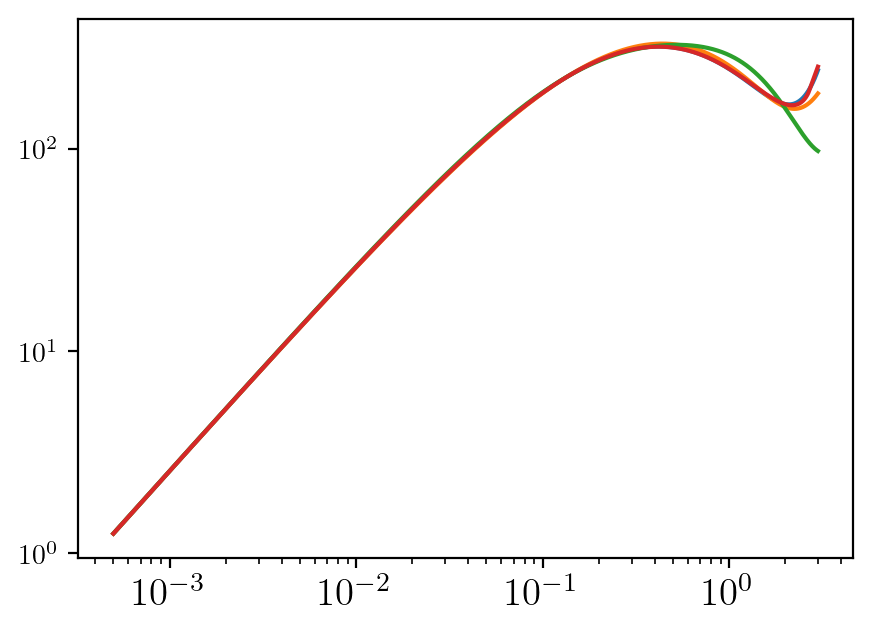

In [6]:
from average_atom.core.physics import More_TF_Zbar
C_kin = 3/40 * (2*π)**2 * (3/π)**(2/3)
b = 1/4 * ((9*π**2)/(2*Z))**(1/3)
print(f"b =  {b:0.3f}")
x = lambda r: r/b # Approximate Solution of the Thomas–Fermi Equation for Free Positive Ions Aleksey A. Mavrin and Alexander V. Demura

η_Roberts = 1.905
Φ_Roberts = lambda x: (1+η_Roberts*np.sqrt(x))*np.exp(-η_Roberts*np.sqrt(x))
n_Roberts_func = lambda r: (5/3*C_kin)**(-1.5) * (Z/r*Φ_Roberts(x(r)))**1.5
Φ_Csavinszky = lambda x: ( 0.7111 * np.exp(- 0.175 * x) + 0.2889 * np.exp(-9.5*0.175 * x))**2
n_Csavinszky_func = lambda r: Z/(4*π*b**3) * (Φ_Csavinszky(x(r))/x(r))**1.5

Φ0_Mavrin_Demura = lambda x: ((1 + 1.81061 * x**(1/2) + 0.60112 * x) / (1 + 1.81061 * x**(1/2) + 1.39515 * x + 0.77112 * x**(3/2) + 0.21465 * x**2 + 0.04793 * x**(5/2)))**2
z = lambda x: np.log(1+x) 
η0_Mavrin_Demura = lambda x: np.exp(z(x) + 0.3837 * z(x)**2 + 0.0892 * z(x)**3 - 0.0170 * z(x)**4) - 1
q = More_TF_Zbar(aa_CS.Z, n_from_rs(aa_CS.rs), aa_CS.Te)/Z
x0_func = lambda q: 10.232/q**(1/3) * (1 - 0.917 * q**0.257) if q<=0.45 else 2.960* ((1-q)/q)**(2/3)
x0 = x0_func(q)
k = -Φ0_Mavrin_Demura(x0)/η0_Mavrin_Demura(x0)
Φ_Mavrin_Demura = lambda x: Φ0_Mavrin_Demura(x) + k * η0_Mavrin_Demura(x)  
n_Mavrin_Demura_func = lambda r: np.nan_to_num(Z/(4*π*b**3) * (Φ_Mavrin_Demura(x(r))/x(r) )**1.5)

# Resulting bound densities
nb_Roberts = n_Roberts_func(aa_CS.core_atom.grid.xs)
nb_Csavinszky = n_Csavinszky_func(aa_CS.core_atom.grid.xs)
nb_Mavrin_Demura = n_Mavrin_Demura_func(aa_CS.core_atom.grid.xs)

# Total bound electrons
Nb_Roberts = aa_CS.core_atom.grid.integrate_f(nb_Roberts)
Nb_Csavinszky = aa_CS.core_atom.grid.integrate_f(nb_Csavinszky)
Nb_Mavrin_Demura = aa_CS.core_atom.grid.integrate_f(nb_Mavrin_Demura)
print(f"Nb_R = {Nb_Roberts:0.3f}, Nb_C = {Nb_Csavinszky:0.3f}, Nb_MD = {Nb_Mavrin_Demura:0.3f}")
#
nf_Roberts = (Z - Nb_Roberts)/aa_CS.core_atom.WSvol * np.ones_like(aa_CS.core_atom.grid.xs)
nf_Csavinszky = (Z - Nb_Csavinszky)/aa_CS.core_atom.WSvol * np.ones_like(aa_CS.core_atom.grid.xs)
nf_Mavrin_Demura = (Z - Nb_Mavrin_Demura)/aa_CS.core_atom.WSvol * np.ones_like(aa_CS.core_atom.grid.xs)

n_Roberts = nb_Roberts + nf_Roberts
n_Csavinszky = nb_Csavinszky + nf_Csavinszky
n_Mavrin_Demura =nb_Mavrin_Demura + nf_Mavrin_Demura

N_Roberts = aa_CS.core_atom.grid.integrate_f(n_Roberts)
N_Csavinszky = aa_CS.core_atom.grid.integrate_f(n_Csavinszky)
N_Mavrin_Demura = aa_CS.core_atom.grid.integrate_f(n_Mavrin_Demura)

print(f"N_R = {N_Roberts:0.3f}, N_C = {N_Csavinszky:0.3f}, N_MD = {N_Mavrin_Demura:0.3f}")

fig, ax = plt.subplots()

geom_factor = 4*π*aa_CS.grid.xs**2
ax.plot(aa_CS.core_atom.grid.xs, geom_factor*aa_CS.core_atom.ne)
ax.plot(aa_CS.core_atom.grid.xs, geom_factor*n_Roberts)
ax.plot(aa_CS.core_atom.grid.xs, geom_factor*n_Csavinszky)
ax.plot(aa_CS.core_atom.grid.xs, geom_factor*n_Mavrin_Demura)

# ax.plot(aa_CS.core_atom.grid.xs, geom_factor*(aa_CS.core_atom.nf))
# ax.plot(aa_CS.core_atom.grid.xs, geom_factor*(aa_CS.core_atom.ne - n_Roberts ))
# ax.plot(aa_CS.core_atom.grid.xs, geom_factor*(aa_CS.core_atom.ne - n_Csavinszky ))
# ax.plot(aa_CS.core_atom.grid.xs, geom_factor*(aa_CS.core_atom.ne - n_Mavrin_Demura ))

ax.set_yscale('symlog', linthresh=1e-1)
ax.set_xscale('log')

